Magic: the Gathering (MTG) was rated by eBay as the most popular card game based on the metric of one item sold per minute. Hasbro's earning reports from the last three quarters show eBay's statement has merit. It's also a personal favorite of mine that I've been playing for over two decades. That's why it's frustrating to me to see so many cards have had to be banned.<br><br>
As a very brief overview, MTG creates four new sets a year for their rotating format, Standard. Only cards printed in the last two years are able to be played in Standard, meaning the pool of cards that can be used is only about 2,000 of the over 50,000 cards that ever have been printed. In thee 27 years since its creation, there have been 33 bans; 14 of those were in the last two years with two of those cards being banned around one month after they were made.<br><br>
So why does that matter? One of the main reasons is that this is an expensive hobby. Competitive players will easily spend over 1,000 dollars per year on the cards to make their decks with 80 percent of that being used on about 5 percent of the cards. Good cards tend to be expensive (because demand and supply) so losing the ability to play with a card you just spent 50 dollars on feels really bad. It can shake customer confidence, depress tournament turnout, and ultimately hurt the game itself. MTG'S R&D team has talked extensively about wanting to ban sparingly to avoid this exact scenario.<br><br>
The next question is why have so many bans happened lately? Most players and content creators (people who give commentary on the game as a whole) have said it's because cards are being made far more powerful in the hopes of selling more product. While Wizards of the Coast, the company that runs MTG and a subsidiary of Hasbro, has tried to have their R&D balance their cards for years, including threatening to fire the entire R&D department when 6 cards had to be banned in 2003, the recent problems led them to create a playtest team specifically tasked with ensuring cards are fun, interesting, and exciting with balance being a slight secondary to this. My answer to this issue is to leverage machine learning to automate as much of the R&D process as possible.<br><br>
Using supervised learning, we can automate much of the card creation process for creatures. Because creatures make up the largest portion of the cards being made each year, the time saved here can be used to better balance the game, potentially leading to less bans and a better format for all MTG players, including myself, to continue enjoying.

In [1]:
#import the necessities
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tools.eval_measures import mse, rmse
%matplotlib inline
warnings.filterwarnings('ignore')

The data was cleaned earlier and the Notebook where that heppened can be found at [https://github.com/CasualChemist/dsf_data/blob/main/Capstone%202%20Sandbox%201.ipynb].<br>
The Notebook where models were tested can be found at [https://github.com/CasualChemist/dsf_data/blob/main/Capstone%202%20Sandbox%202.ipynb].<br>
The Notebook where the targets were tested can be found at [https://github.com/CasualChemist/dsf_data/blob/main/Capstone%202%20Sandbox%203.ipynb]

In [2]:
#get our data that will train our model
recent_cards = pd.read_csv('D:/DSF Files/recentcards.txt', sep = '\t')

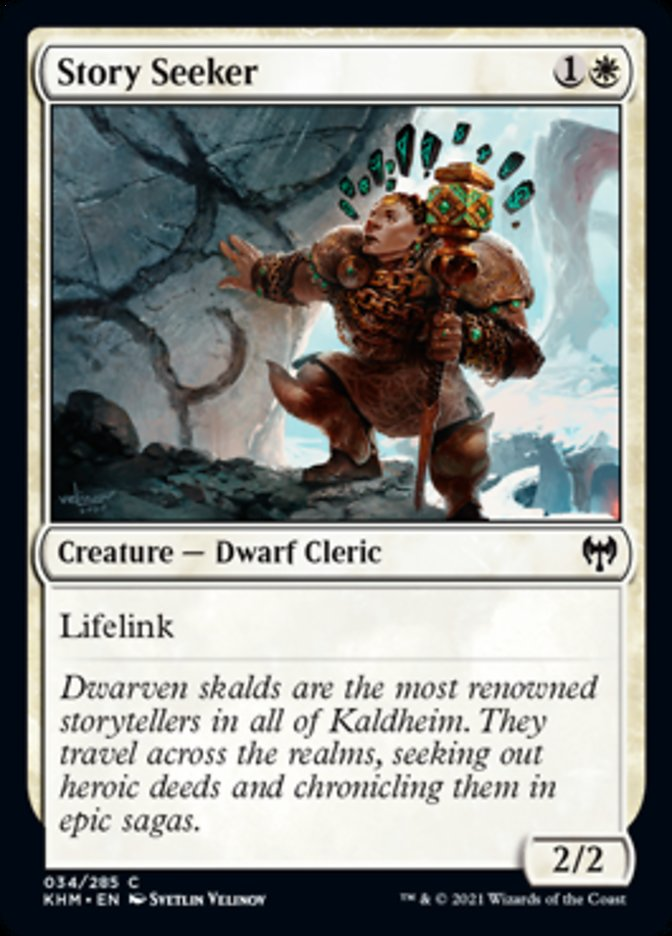

There are many aspects to the MTG card shown above. In the upper right is the Mana cost, symbolized by colored pip and a gray number. Below that in the middle right of the card is the set symbol which denotes the rarity of the card and the set it is from. In the bottom right is the power and toughness. In the middle left is the keyword which explains any extra abilities the card might have. As a note, the italicized text below that is called flavor text which has no bearing on the game but can have humorous lines meant to make the card more interesting. There are other aspects of cards such as sub-types (Dwarf Cleric above), types (Creature), and name (Story Seeker) but we are not worried about those since we are focusing on creatures, names have zero bearing on card creation, and sub-types tend to be determined by the set rather than having a regular distribution.<br><br>
The question is "Can we use machine learning to automate the card creation process, and if so, what factors?" Let's start by looking at the data that has been pared down to the relevant attributes.

In [3]:
display(recent_cards.info())
display(recent_cards.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   White                2072 non-null   int64
 1   Blue                 2072 non-null   int64
 2   Black                2072 non-null   int64
 3   Red                  2072 non-null   int64
 4   Green                2072 non-null   int64
 5   Uncommon             2072 non-null   int64
 6   Rare                 2072 non-null   int64
 7   Mythic               2072 non-null   int64
 8   Converted Mana Cost  2072 non-null   int64
 9   Specific Mana Cost   2072 non-null   int64
 10  Power                2072 non-null   int64
 11  Toughness            2072 non-null   int64
 12  Legendary            2072 non-null   int64
 13  EG Keywords          2072 non-null   int64
 14  Set Keywords         2072 non-null   int64
dtypes: int64(15)
memory usage: 242.9 KB


None

,White,Blue,Black,Red,Green,Uncommon,Rare,Mythic,Converted Mana Cost,Specific Mana Cost,Power,Toughness,Legendary,EG Keywords,Set Keywords
0,1,0,0,0,0,0,0,0,4,1,3,2,0,1,0
1,1,0,0,0,0,1,0,0,4,2,2,4,1,1,0
2,1,0,0,0,0,0,0,0,2,1,2,2,0,0,0
3,1,0,0,0,0,0,1,0,3,3,3,3,0,0,0
4,1,0,0,0,0,0,0,0,3,1,3,2,0,0,0


Because we are only using creatures printed in the last two years, we have 1872 non-null values for each column. The columns and their explanations are below:<br>
White, Blue, Black, Red, Green: Nominal. Collectively, this is known as Color. If all of the values are 0, the card is colorless. This is found by looking at the color of the pip(s) in the upper right. For Story Seeker, it is White.<br>
Legendary: Nominal. Legendary creatures tend to be a little more powerful than their normal counterparts. For Story Seeker, it is not Legendary
Uncommon, Rare, Mythic: Ordinal. Collectively, this is known as rarity. Mythic cards are far less plentiful than the others with Rares being less plentiful than Uncommons. If all of the values are 0, the card is colorless. Mythics tend to be the strongest with commons being the weakest. For Story Seeker, it is common.<br>
Converted Mana Cost: Ratio. This is the number found if you add the number in the gray circle and the pips (where pips are equal to 1). For Story Seeker, this is 2.<br>
Specific Cost: Ratio. This is the number you get if you count the pips in the upper right. For Story Seeker, this is 1.
Power: Ratio. This is the number before the / in the bottom right. It represents how much damage the creature can do to other creatures or opponent players. For Story Seeker, this is 2.<br>
Toughness: Ratio. power: Ratio. This is the number after the / in the bottom right. It represents how much damage the creature can do to other creatures or opponent players. For Story Seeker, this is 2.<br>
EG Keywords: Nominal. EG (Evergreen) abilities can appear in any set and tend to have different keywords appear based on the creature's color. For Story Seeker, this is Lifelink.<br>
Set Keywords: Set keywords only appear in that specific set and are generally spread across multiple colors. For Story Seeker, it has no Set Keyword.<br><br>
As far as card attributes, Color, Rarity, and Converted Mana Cost vary little by set and as such pulling data from previous sets as a baseline can be done. Using those, we can find the Specific Cost, then Power, then Toughness, then Legendary, then EG Keywords, and finally Set Keywords. It should be noted that since EG Keywords and Set Keywords have over 100 different possible values, we are looking at the sum of possible keywords which will be filled based on the color of the creature.

In [4]:
def d_tree_boosted(depth):
    targets = ['Specific Mana Cost', 'Power', 'Toughness', 'Legendary',
              'EG Keywords', 'Set Keywords']
    attributes = ['Specific Mana Cost', 'Power', 'Toughness', 'Legendary',
              'EG Keywords', 'Set Keywords']
    predictions = pd.DataFrame()
    print('Decision Tree Regression')
    for target in targets:
        y = recent_cards[target]
        X = recent_cards.drop(attributes, axis=1)
        attributes.pop(0)
        print('\nThe results for {} as the target in the Decision Tree Regessor:'.format(target))
        for n in range(0, 101):
            decision_tree = DecisionTreeRegressor(max_depth=depth)
            decision_tree.fit(X, y)
            predict = decision_tree.predict(X)
            predictions['predictions {}'.format(n)] = predict
            y = y - predict
        predicted = predictions.sum(axis=1)
        print(np.corrcoef(recent_cards[target], predicted)[0, 1])

In [5]:
d_tree_boosted(4)

Decision Tree Regression

The results for Specific Mana Cost as the target in the Decision Tree Regessor:
0.8658218203322351

The results for Power as the target in the Decision Tree Regessor:
0.8577705230347075

The results for Toughness as the target in the Decision Tree Regessor:
0.9279530949812421

The results for Legendary as the target in the Decision Tree Regessor:
0.8864599603196075

The results for EG Keywords as the target in the Decision Tree Regessor:
0.7770950812186038

The results for Set Keywords as the target in the Decision Tree Regessor:
0.741489350670608


The results for the targets are as follows:<br>
Specific Mana Cost: 86.58%.<br>
Power: 85.77%.<br>
Toughness: 92.79%.<br>
Legendary: 88.64%.<br>
EG Keywords: 77.70%.<br>
Set Keywords 74.15%.<br><br>
Using information that has minimal changes between sets, specifically the number of (Converted Mana Cost) (White, Blue, Black, Red, Green, Colorless) (Rarity) Creatures per set, we can create a baseline for future sets. You can further tune it based on specific sets by using the Set Code -- a value removed from consideration -- in order to have it be a specific 'power level' exemplified by the previous set.<br><br>
It is important to note that this can not and will not remove the human element of card design. Each card is different by design and there are plenty of intangibles that could not be quantified for use in this model. This would merely give a shell that can be molded as needed. It could also be used once the set has been created to compare it to the previous sets.